# Imagenet Processing in parallel

In [1]:
%matplotlib inline
from importlib import reload
import utils2; reload(utils2)
from utils2 import *
import utils2_ted; reload(utils2_ted)
from utils2_ted import *

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from bcolz_array_iterator import BcolzArrayIterator
from tqdm import tqdm

In [3]:
limit_mem()

This is where our full dataset lives. It's slow spinning discs, but lots of room!

**NB:** We can easily switch to and from using a sample. We'll use a sample for *everything*, except the final complete processing (which we'll use fast/expensive compute for, and time on the sample so we know how long it will take).

In [4]:
#path = '../../../Data/imagenet-sample-train/'
path = '../data2/train/'

This is on a RAID 1 SSD for fast access, so good for resized images and feature arrays

In [5]:
#dpath = '../../../Data/'
dpath = '../data2/'

Note that either way, AWS isn't going to be a great place for doing this kind of analysis - putting a model into production will cost at minimum $600/month for a P2 instance. For that price you can **buy** a GTX 1080 card, which has **double** the performance of the AWS P2 card! And you can set up your slow full data RAID 5 array and your fast preprocessed data RAID 1 array just as you like it. Since you'll want your own servers for production, you may as well use them for training, and benefit from the greater speed, lower cost, and greater control of storage resources.

You can put your server inside a colo facility for very little money, paying just for the network and power. (Cloud providers aren't even allowed to provide GTX 1080's!)

There's little need for distributed computing systems for the vast majority of training and production needs in deep learning.

## Get word vectors

First we need to grab some word vectors, to use as our dependent variable for the image model (so that the image vectors and word vectors will be in the same space). After loading the word vectors, we'll make sure that the names of the wordnet/imagenet are in the word list.

* Be careful not to just follow paper's approach - e.g. here word2vec better than custom wikipedia vectors. word2vec has multi-word tokens like 'golden retriever'
* Take evaluations shown in papers with a grain of salt, and do your own tests on important bits. E.g. DeVISE (because it's an older paper) used an old and inaccurate image model, and poor word vectors, so recent papers that compare to it aren't so relevent

In [6]:
# get data by: wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" -P $dpath
#!gzip -d $dpath"GoogleNews-vectors-negative300.bin.gz"

In [7]:
from gensim.models import word2vec

w2v_path= dpath+'GoogleNews-vectors-negative300'

In [8]:
# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
model = word2vec.KeyedVectors.load_word2vec_format(w2v_path+".bin", binary=True)
model.save_word2vec_format(w2v_path+'.txt', binary=False)

In [9]:
lines = open(w2v_path+'.txt', encoding='utf-8').readlines()

In [10]:
def parse_web2v(l):
    i = l.index(' ')
    return l[:i], np.fromstring(l[i:], dtype=np.float32, sep=' ')

In [11]:
w2v_list = list(map(parse_web2v, lines[1:]))

In [12]:
len(w2v_list)

3000000

In [13]:
pickle.dump(w2v_list, open(path+'w2v1.pkl', 'wb'), pickle.HIGHEST_PROTOCOL)

In [8]:
w2v_list = pickle.load(open(path+'w2v1.pkl', 'rb'))

We save the processed file so we can access it quickly in the future. It's a good idea to save any intermediate results that take a while to recreate, so you can use them both in production and prototyping.

In [9]:
w2v_dict = dict(w2v_list)
words, vectors = zip(*w2v_list)

Always test your inputs! If you're not sure what to look for, try to come up with some kind of reasonableness test.

In [10]:
np.corrcoef(w2v_dict['ted'], w2v_dict['Ted'])

array([[ 1.        , -0.00491573],
       [-0.00491573,  1.        ]])

In [11]:
np.corrcoef(w2v_dict['king'], w2v_dict['King'])

array([[1.        , 0.51712269],
       [0.51712269, 1.        ]])

In [12]:
lc_w2v = { w.lower(): w2v_dict[w] for w in reversed(words)}

In [13]:
len(lc_w2v)

2702150

We're going to map word vectors for each of:
* The 1000 categories in the Imagenet competition
* The 82,000 nouns in Wordnet

In [14]:
fpath = get_file('imagenet_class_index.json', 
                 'http://www.platform.ai/models/imagenet_class_index.json', 
                 cache_subdir='models')
class_dict = json.load(open(fpath))
nclass = len(class_dict)
print(nclass)
classids_1k = dict(class_dict.values())
print(len(classids_1k))

1000
1000


download imagenet class_ids from http://image-net.org/archive/words.txt

In [15]:
classid_lines = open('words.txt', 'r', encoding='utf-8').readlines()
classids = dict([l.strip().split('\t') for l in classid_lines])
len(classids)

82115

In [16]:
syn_wv = [(k, lc_w2v[v.lower()]) for k,v in classids.items() 
          if v.lower() in lc_w2v]
syn_wv_1k = [(k, lc_w2v[v.lower()]) for k,v in classids_1k.items() 
          if v.lower() in lc_w2v]

syn2wv = dict(syn_wv); print(len(syn2wv))

22508


In [17]:
nomatch = [v[0] for v in class_dict.values() if v[0] not in syn2wv]; len(nomatch)

705

In [18]:
nm_path=path+'train_nm/'
#os.mkdir(nm_path)
#for nm in nomatch:
#    if os.path.exists(path+nm): os.rename(path+nm, nm_path+nm)

print(len(glob.glob(path+'n*')))
print(len(glob.glob(nm_path+'n*')))

295
479


In [19]:
ndim = len(list(syn2wv.values())[0]); ndim

300

## Resize images

Now that we've got our word vectors, we need a model that can create image vectors. It's nearly always best to start with a pre-train image model, and these require a specific size input. We'll be using resnet, which requires 224x224 sized images. Reading jpegs and resizing them can be slow, so we'll store the result of this.

First we create the filename list for the imagenet archive:

In [20]:
fnames = list(glob.iglob(path+'*/*.JPEG')); print(len(fnames))
pickle.dump(fnames, open(path+'fnames.pkl', 'wb'))

7447


Even scanning a large collection of files is slow, so we save the filenames:

In [21]:
fnames = pickle.load(open(path+'fnames.pkl', 'rb'))

In [22]:
fnames = np.random.permutation(fnames)

In [23]:
pickle.dump(fnames, open(path+'fnames_rand.pkl', 'wb'))

In [24]:
fnames = pickle.load(open(path+'fnames_rand.pkl', 'rb'))

In [25]:
new_s = 224 # height and width to resize to
n = len(fnames); n

7447

In [26]:
bc_path = f'{dpath}/trn_resized_{new_s}_r.bc'

Using pillow to resize the image (recommendation: install pillow-simd for 600% speedup). To install, force remove the conda installed version, then:

    CC="cc -mavx2" pip install -U --force-reinstall pillow-simd
    
[pillow-simd](https://github.com/uploadcare/pillow-simd)

In [27]:
from PIL import Image

In [28]:
def _resize(img):
    shortest = min(img.width, img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

In [29]:
def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    if len(s)!=3 or s[2]!=3: return
    return _resize(img)

In [30]:
def resize_img_bw(i):
    return _resize(Image.open(fnames[i]).convert('L'))

Pre-allocate memory in threadlocal storage

In [31]:
t1 = threading.local()

In [32]:
t1.place = np.zeros((new_s, new_s, 3), 'uint8')

Bcolz is amazingly fast, easy to use, and provides a largely numpy-compatible interface. It creates file-backed arrays and are transparently cached in memory.

Create (or open) compressed array for our resized images

In [33]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), 
             chunklen=16, mode='w', rootdir=bc_path)

Function that appends resized image with black border added to longer axis

In [34]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(r):
    t1.place[:] = (np.array(r)[get_slice(r.size[1], new_s), get_slice(r.size[0], new_s)]
                  if r else 0.)
    arr.append(t1.place)

(334, 500, 3)
(224, 335, 3)
(224, 224, 3)


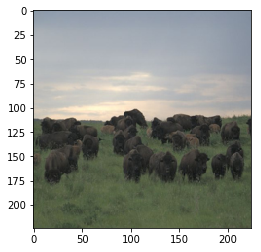

In [61]:
# Test Case for Resize
i = 210
img = Image.open(fnames[i])
print(np.array(img).shape)
print(np.array(_resize(img)).shape)
r = _resize(img)
result = (np.array(r)[get_slice(r.size[1], new_s), get_slice(r.size[0], new_s)]
                  if r else 0.)
print(result.shape)
plt.imshow(np.array(result))